In [1]:
# import custom libraries
import text_parsing_utils as util
import optimizers 
import cost_functions as costs
import classification_static_plotter
plotter = classification_static_plotter.Visualizer()

# import autograd functionality
import autograd.numpy as np

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# generate chars and tokens

In [2]:
# load in and preprocess text
csvname = "war_of_the_worlds.txt"
text = util.load_preprocess(csvname)

In [3]:
# parse into individual characters
chars,keys,chars_to_keys,keys_to_chars = util.parse_chars(text)

# Generate training data

In [56]:
num_chars = len(chars)
unique_chars = len(np.unique(chars))

order = 10
x_orig = []
y = []
for i in range(order,num_chars):
    # grab current key, and previous order keys
    next_key = keys[i]
    prev_keys = np.array(keys[i-order:i])
    
    # collect
    x_orig.append(prev_keys)
    y.append(next_key)
x_orig = np.array(x_orig).T
y = np.array(y)
y+=1

# Markov model training - characters

In [57]:
# a normalization function 
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [58]:
# normalize a dataset
x_means = np.mean(x_orig,axis = 1)[:,np.newaxis]
x_stds = np.std(x_orig,axis = 1)[:,np.newaxis]

# normalize data using the function above
x_normalized = normalize(x_orig,x_means,x_stds)

In [59]:
# generate cost function
softmax = costs.Setup(x_normalized,y,cost = 'multiclass_softmax').cost_func
multiclass_counter = costs.Setup(x_normalized,y,cost = 'multiclass_counter').cost_func 

In [71]:
w = 0.1*np.random.randn(order + 1,unique_chars);
max_its = 100
alpha_choice = 1
g = softmax
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

In [72]:
count_history_1 = [multiclass_counter(v) for v in weight_history_1]

In [62]:
# generate cost function
minibatch_softmax = costs.Setup(x_normalized,y,cost = 'minibatch_multiclass_softmax').cost_func

In [63]:
g = minibatch_softmax
max_its = 10
alpha_choice = 10**(-1)
batch_size = 1000
weight_history_2,cost_history_2 = optimizers.minibatch_gradient_descent(g,alpha_choice,max_its,w,batch_size,len(y))
count_history_2 = [multiclass_counter(v) for v in weight_history_2]

<IPython.core.display.Javascript object>


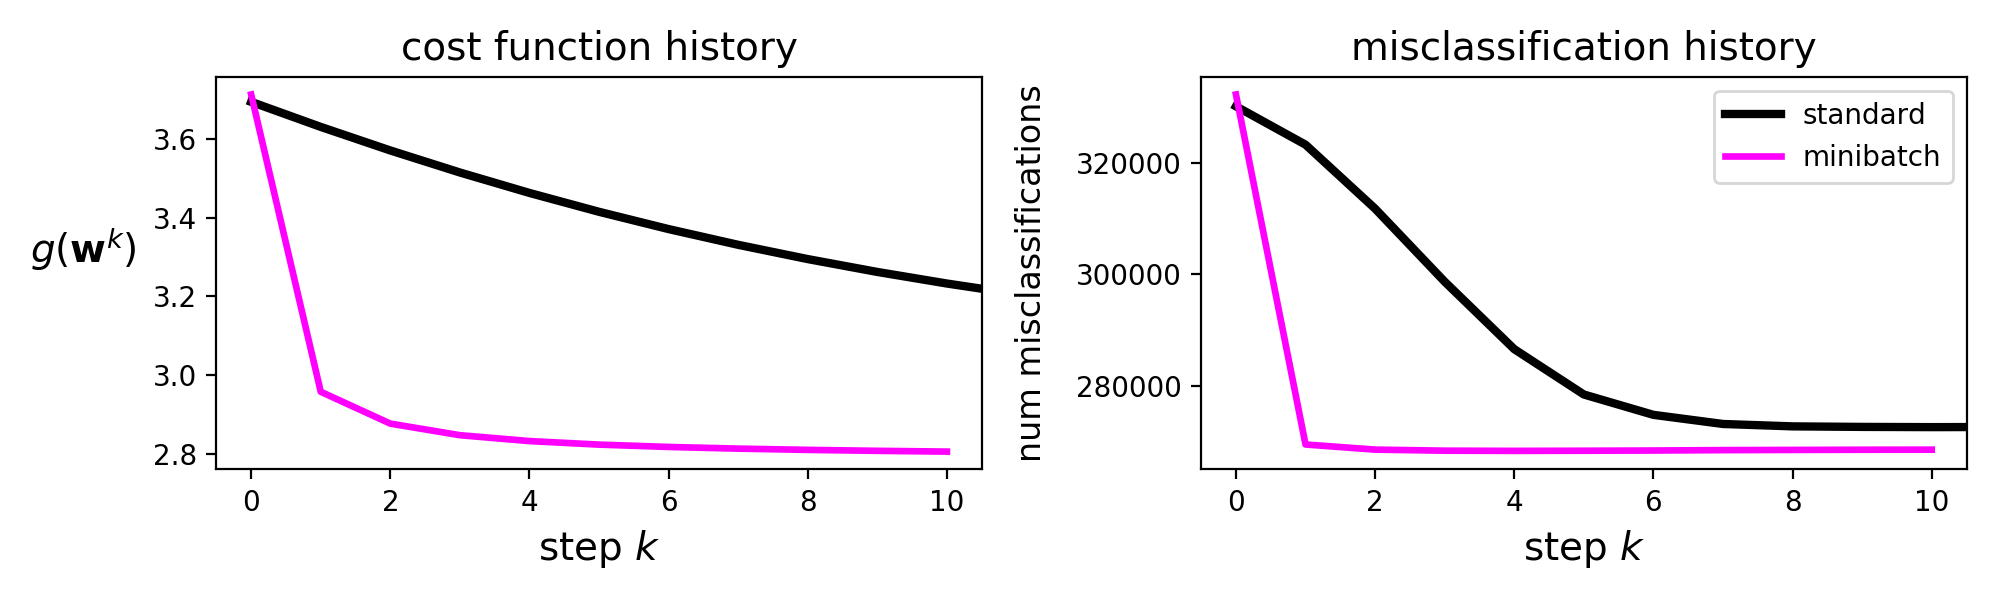

In [73]:
# plot the cost function history for a given run
plotter.plot_cost_histories([weight_history_1,weight_history_2],[cost_history_1,cost_history_2],[count_history_1,count_history_2],start = 0,labels = ['standard','minibatch'])

In [74]:
count_history_1[-1]

268328

In [75]:
count_history_2[-1]

268656

# Generate new text

In [65]:
# use transition matrix to generate sentence of desired length
# starting at randomly chosen word (all of this is done using
# the associated keys, then re-translated into words)
starter_ind = np.random.permutation(keys)[0]
generated_keys = keys[starter_ind:starter_ind+order]

In [76]:
w_eval = weight_history_1[-1]
num_produce = 100   # number of words to produce
for i in range(num_produce):
    # get previous keys
    prev_keys = np.array(generated_keys[i:i+order])[:,np.newaxis]
    
    # normalize using training mean / std
    prev_keys_normalized = normalize(prev_keys,x_means,x_stds)
    
    # get fusion rule
    fusion_rule = costs.Setup(prev_keys_normalized,[],cost = 'fusion_rule').cost_func 
    next_key = fusion_rule(w_eval) + 1
    
    # store next key
    generated_keys.append(next_key[0])

In [77]:
# translate generated keys back into characters and print
generated_chars = ''
for key in generated_keys:
    next_char = keys_to_chars[key]
    generated_chars += next_char

In [78]:
print (generated_chars)

he worlds "vg"vj"vj""cc"vg"vg"vj""cc"vg"vg"vj""cc"vg"vg"vj""cc"vg"vg"vj""cc"vg"vg"vj""cc"vg"vg"vj""cc"vg"vg"vj"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j""cc"vg"vj""j


In [70]:
x_normalized.shape

(10, 338635)